To show off a recent command line tool for sketching, [dsrs](https://github.com/vlad17/datasketches-rs), let's plot the rolling 28-day average daily count of active reviewers on Amazon.

The raw data here is `item,user,rating,timestamp` so this would map to a sophisticated `GROUP BY` with a `COUNT DISTINCT` over 28-day windows in SQL. But since the data's only available as CSV, how can we get to the same answer? If we're just interested in an approximate solution, can we do this without using a bunch of memory or custom (shuffle-inducing...) sliding window implementation?

All timings below done on a 16-physical CPU machine (AWS r4.8xlarge).

In [1]:
# https://nijianmo.github.io/amazon/index.html
# 6.7gb
# May 1996 - Oct 2018, e.g.:
# 0449819906,A3U4E9PIZ8OWH1,5.0,1383696000
# timestamp is then unix time in seconds.
prefix = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/'
review_data = {
  'Amazon Fashion': 'AMAZON_FASHION.csv',
  'All Beauty': 'All_Beauty.csv',
  'Appliances': 'Appliances.csv',
  'Arts, Crafts and Sewing': 'Arts_Crafts_and_Sewing.csv',
  'Automotive': 'Automotive.csv',
  'Books': 'Books.csv',
  'CDs and Vinyl': 'CDs_and_Vinyl.csv',
  'Cell Phones and Accessories': 'Cell_Phones_and_Accessories.csv',
  'Clothing, Shoes and Jewelry': 'Clothing_Shoes_and_Jewelry.csv',
  'Digital Music': 'Digital_Music.csv',
  'Electronics': 'Electronics.csv',
  'Gift Cards': 'Gift_Cards.csv',
  'Grocery and Gourmet Food': 'Grocery_and_Gourmet_Food.csv',
  'Home and Kitchen': 'Home_and_Kitchen.csv',
  'Industrial and Scientific': 'Industrial_and_Scientific.csv',
  'Kindle Store': 'Kindle_Store.csv',
  'Luxury Beauty': 'Luxury_Beauty.csv',
  'Magazine Subscriptions': 'Magazine_Subscriptions.csv',
  'Movies and TV': 'Movies_and_TV.csv',
  'Musical Instruments': 'Musical_Instruments.csv',
  'Office Products': 'Office_Products.csv',
  'Patio, Lawn and Garden': 'Patio_Lawn_and_Garden.csv',
  'Pet Supplies': 'Pet_Supplies.csv',
  'Prime Pantry': 'Prime_Pantry.csv',
  'Software': 'Software.csv',
  'Sports and Outdoors': 'Sports_and_Outdoors.csv',
  'Tools and Home Improvement': 'Tools_and_Home_Improvement.csv',
  'Toys and Games': 'Toys_and_Games.csv',
  'Video Games': 'Video_Games.csv'
}
review_data = {k: prefix + v for k, v in review_data.items()}

Even with a 28d sliding window, if we're sliding by a day, it's still quite a few data points.

In [2]:
import pandas as pd
(pd.Timestamp('Oct 2018') - pd.Timestamp('May 1996')) / pd.Timedelta('1d')

8188.0

Store all urls in a variable

In [3]:
from shlex import quote
urls = ' '.join(list(map(quote, review_data.values())))

In [4]:
%%bash -s {urls}

echo 'will cite' | parallel --citation 1> /dev/null 2> /dev/null 

parallel curl -o "/tmp/amazon{#}.csv" -s {} ::: "$@"

In [5]:
%%bash

# Total data size
du -hsc /tmp/amazon*.csv | tail -1

# How many reviews?
parallel --pipepart wc -l :::: /tmp/amazon*.csv \
  | awk '{s+=$1}END{print s}'

9.0G	total
230139802


In [6]:
%%bash

# How many users?
parallel --pipepart 'cut -d, -f2 | dsrs --raw' :::: /tmp/amazon*.csv \
  | dsrs --merge

43404924


In [7]:
%%writefile /tmp/date-user-extract.awk
#!/usr/bin/awk

BEGIN {
    FS = "," 
}

1 {
    user = $2;
    epoch_sec = $4;
    # round down to nearest day
    rounded_epoch_sec = strftime("%Y %m %d 00 00 00", epoch_sec);
    rounded_epoch_sec = mktime(rounded_epoch_sec)
    for (i = 0; i < 28; i += 1) {
        dt = strftime("%F", rounded_epoch_sec);
        print dt " " user
        # a day can be more than this many seconds due to leaps but
        # since we only decrement 28 times the undershoot doesn't matter
        rounded_epoch_sec -= 86400
    }
}

Overwriting /tmp/date-user-extract.awk


In [8]:
%%bash

# test date mapper
echo 0449819906,A3U4E9PIZ8OWH1,5.0,1383696000 | awk -f /tmp/date-user-extract.awk | head -3

2013-11-06 A3U4E9PIZ8OWH1
2013-11-05 A3U4E9PIZ8OWH1
2013-11-04 A3U4E9PIZ8OWH1


In [9]:
%%bash
  
# How many 28d users?
parallel --pipepart 'awk -f /tmp/date-user-extract.awk' :::: /tmp/amazon*.csv \
  | dsrs --key >/tmp/ts

In [10]:
t = pd.read_csv('/tmp/ts', delimiter=' ', names=["date", "cnt"])
t.set_index("date", inplace=True, verify_integrity=True)
t.sort_index(inplace=True)
t.head()

,cnt
date,
1996-04-23,1
1996-04-24,1
1996-04-25,1
1996-04-26,1
1996-04-27,1


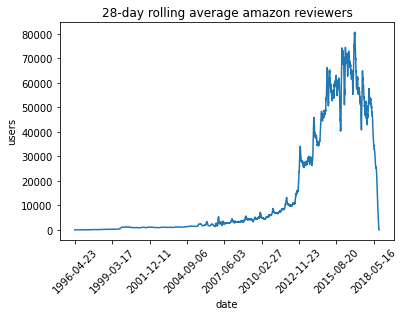

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
(t/28).plot(rot=45, legend=False)
plt.xlabel("date")
plt.ylabel("users")
plt.title("28-day rolling average amazon reviewers")
plt.show()

In [12]:
%%bash

start=`date +%s`
parallel --pipepart 'cut -d, -f2' :::: /tmp/amazon*.csv \
  | awk '{a[$1]=1}END{print length(a)}'
end=`date +%s`
echo "How many users? awk time" $((end-start)) "sec"
echo

start=`date +%s`
parallel --pipepart 'cut -d, -f2' :::: /tmp/amazon*.csv \
  | dsrs
end=`date +%s`
echo "How many users? serial sketching time" $((end-start)) "sec"
echo

start=`date +%s`
parallel --pipepart 'cut -d, -f2 | dsrs --raw' :::: /tmp/amazon*.csv \
  | dsrs --merge
end=`date +%s`
echo "How many users? parallel sketching time" $((end-start)) "sec"

43249276
How many users? awk time 190 sec

43206238
How many users? serial sketching time 11 sec

43404924
How many users? parallel sketching time 4 sec


I tried comparing the sketch-based rolling average computation to an `awk` one:

```
parallel --pipepart 'awk -f /tmp/date-user-extract.awk' :::: /tmp/amazon*.csv \
  | awk '{a[$1][$2]=1}END{for(i in a)print i " " length(a[i])}' >/tmp/ts-awk
```

But this got OOM killed after 2700 seconds on a 240GB RAM machine. Perhaps the easiest non-sketch approach here would require ingesting the CSVs into postgres and just using a window function, but at this point we're well over a few-line solution.